In [1]:
%pip install river pandas==2.2.2 scipy==1.13.1 numpy==1.26.1 matplotlib scikit-learn fastdtw


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3.10 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Teste da SmartWindow

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from collections import deque

# Importando as classes necessárias
from utils.SeriesProcessor import SeriesProcessor
from utils.Visualizer import Visualizer
from classes.smartWindow.Smart_window import SmartWindow

## 1. Preparação dos Dados

In [30]:
# Lista de séries temporais disponíveis
series = [
    "AAPL",
    "B3SA3.SA",
    "^IXIC",
    "^DJI",
    "^GSPC",
    "^BVSP",
    "USDBRL=X"
]

# Definindo parâmetros para processamento
lags = 5
serie_escolhida = series[-2] # Exemplo: ^BVSP
print(f"Processando série: {serie_escolhida}")

# Baixando os dados
serie_temporal = SeriesProcessor.baixar_dados(serie_escolhida)

# Normalizando a série temporal
serie_temporal_normalizada = SeriesProcessor.normalizar_serie(serie_temporal)
print(f"Shape da série após normalização: {serie_temporal_normalizada.shape}")

# Gerando janelas temporais
X, Y = SeriesProcessor.criar_janela_temporal(serie_temporal_normalizada, lags)
print(f"Shape dos dados de entrada (X): {X.shape}")
print(f"Shape dos dados de saída (Y): {Y.shape}")

Processando série: ^BVSP


[*********************100%***********************]  1 of 1 completed

Shape da série após normalização: (1245, 1)
Shape dos dados de entrada (X): (1240, 5)
Shape dos dados de saída (Y): (1240, 1)


## 2. Testando a SmartWindow

In [35]:
# Parâmetros da SmartWindow
TAM_JANELA = 50
MAX_JANELAS = 5
LIMIAR_DRIFT = 0.23 # Ajustado: Aumentado para reduzir sensibilidade
LIMIAR_DTW = 40    # Ajustado: Diminuído para seleção mais rigorosa

# Instanciar SmartWindow com um modelo base (LinearRegression por padrão)
smart_window = SmartWindow(
    tam_janela=TAM_JANELA,
    max_janelas=MAX_JANELAS,
    limiar_drift=LIMIAR_DRIFT,
    limiar_dtw=LIMIAR_DTW,
    modelo=RandomForestRegressor() # Pode especificar outro modelo compatível com scikit-learn
)

predicoes = []
drifts_detectados_indices = []
modelo_treinado_inicialmente = False

# Iterar sobre os dados ponto a ponto
for i in range(len(X)):
    x_i = X[i]
    y_i = Y[i]

    # Fazer predição ANTES de processar o ponto
    # O modelo só está pronto para prever após a primeira janela ser processada
    y_pred_i = np.nan # Valor padrão caso o modelo ainda não esteja treinado
    if modelo_treinado_inicialmente:
        try:
            # Garantir que x_i seja 2D para predict
            x_i_reshaped = np.array(x_i).reshape(1, -1)
            y_pred_i = smart_window.modelo.predict(x_i_reshaped)[0]
        except Exception as e:
            print(f"Erro na predição no índice {i}: {e}")
            # Mantém y_pred_i como NaN ou outro valor indicativo

    predicoes.append(y_pred_i)

    # Processar o ponto atual com a SmartWindow
    drift_detectado = smart_window.processar_ponto(x_i, y_i)

    # Marcar se o modelo foi treinado pela primeira vez
    if not modelo_treinado_inicialmente and len(smart_window.janelas) > 0:
         modelo_treinado_inicialmente = True

    # Registrar drift
    if drift_detectado:
        drifts_detectados_indices.append(i)
        print(f"Drift detectado no índice: {i}")

# Converter predições para array numpy
predicoes = np.array(predicoes)

# Calcular MAE e Desvio Padrão (ignorando NaNs iniciais)
mask = ~np.isnan(predicoes)
if np.any(mask):
    y_true_masked = Y[mask].ravel() # Garante 1D
    predicoes_masked = predicoes[mask]
    if len(y_true_masked) == len(predicoes_masked):
        erros_absolutos = np.abs(y_true_masked - predicoes_masked)
        mae = np.mean(erros_absolutos)
        std_dev_erro = np.std(erros_absolutos)
        print(f"\nMAE Final: {mae:.4f}")
        print(f"Desvio Padrão do Erro Absoluto: {std_dev_erro:.4f}")
    else:
        print(f"\nAviso: Discrepância de tamanho ao calcular métricas. Y mask: {len(y_true_masked)}, Pred mask: {len(predicoes_masked)}")
else:
    print("\nNão foi possível calcular MAE/StdDev (nenhuma predição válida).")

print(f"Total de drifts detectados: {len(drifts_detectados_indices)}")

Drift detectado no índice: 69
Drift detectado no índice: 150
Drift detectado no índice: 171
Drift detectado no índice: 272
Drift detectado no índice: 374
Drift detectado no índice: 420
Drift detectado no índice: 473
Drift detectado no índice: 539
Drift detectado no índice: 812
Drift detectado no índice: 890
Drift detectado no índice: 930

MAE Final: 0.1951
Desvio Padrão do Erro Absoluto: 0.1663
Total de drifts detectados: 11


## 3. Visualização dos Resultados


Drift detectado para SmartWindow nos índices: [69, 150, 171, 272, 374, 420, 473, 539, 812, 890, 930]


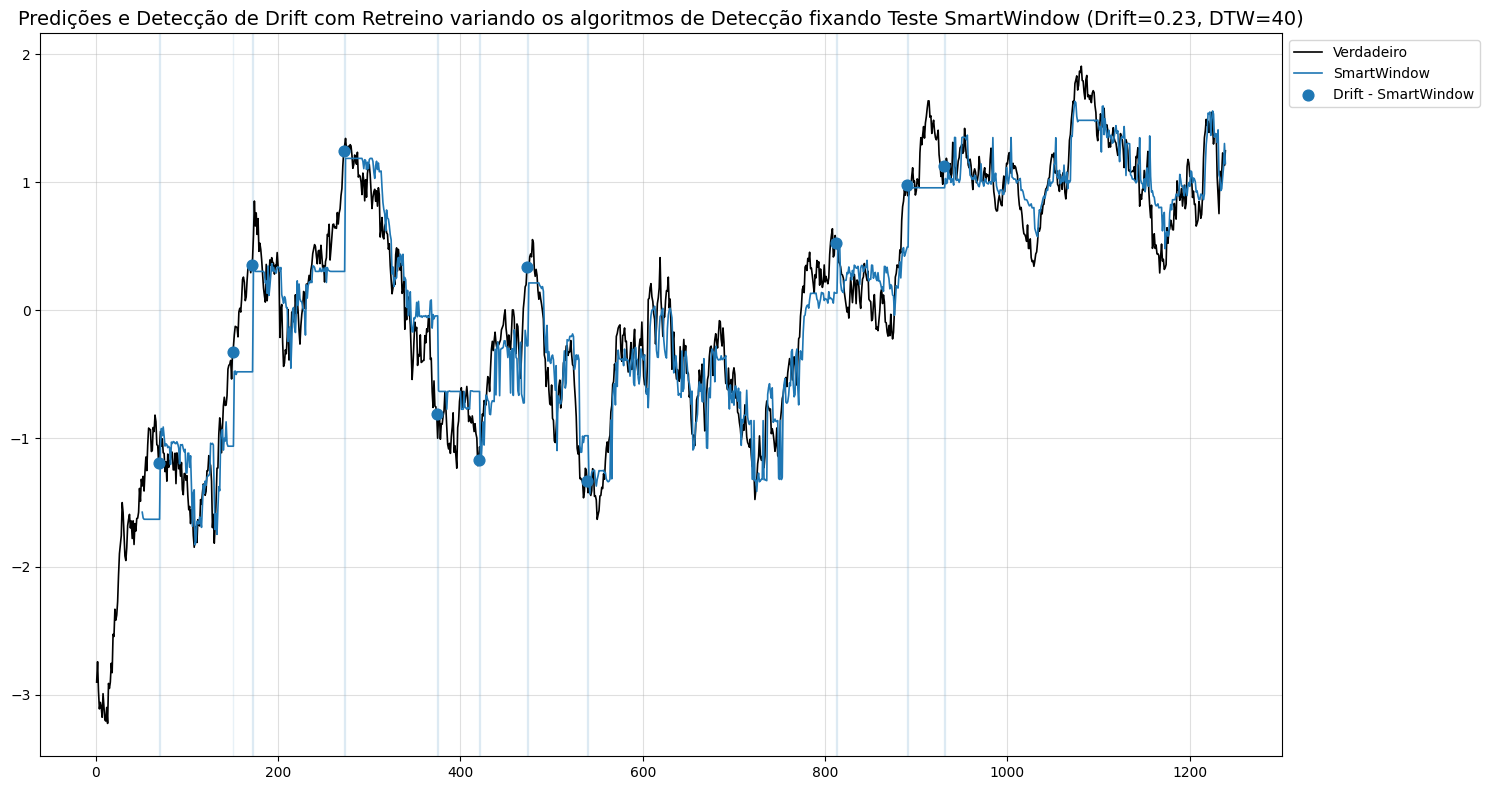

In [36]:
# Preparar dados para visualização
# O Visualizer.plotar_resultados espera uma estrutura específica
# Vamos adaptar a chamada ou preparar os dados

resultados_dict = {'SmartWindow': predicoes}
deteccoes_dict = {'SmartWindow': drifts_detectados_indices}

# Plotar os resultados
Visualizer.plotar_resultados_multi(
    Y, # Valores reais
    list(resultados_dict.values()), # Lista de arrays de predições
    list(resultados_dict.keys()), # Lista de nomes dos 'modelos'
    deteccoes_dict, # Dicionário com índices de drift por 'modelo'
    tamanho_batch=1, # Como processamos ponto a ponto, o 'batch' é 1
    detector_or_modelo=f"Teste SmartWindow (Drift={LIMIAR_DRIFT}, DTW={LIMIAR_DTW})" # Atualiza título com novos parâmetros
)